In [1]:
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme
import matplotlib.pyplot as plt

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 0, 0],  # activities
    [1, 0, 0],  # abundances
)


P, sequence_graph = simulate_proteolysis(
    pr39,
    n_start=10,
    n_generate=500,
    endo_or_exo_probability=[0.5, 0.5],
    enzymes=enzymes,
)

 499 / 500
91 unique peptides. 510 total


/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 58 / 500 | 10.14, mean: 8.85 | Increasing | nz: 714
Learning rate decreased to 1.0
 109 / 500 | 8.70, mean: 9.14 | Increasing | nz: 714
Learning rate decreased to 0.5
 161 / 500 | 9.31, mean: 8.97 | Increasing | nz: 7144
Learning rate decreased to 0.25
 212 / 500 | 8.49, mean: 8.99 | Increasing | nz: 7140
Learning rate decreased to 0.125
 262 / 500 | 9.11, mean: 8.74 | Increasing | nz: 7113
Learning rate decreased to 0.0625
 314 / 500 | 8.43, mean: 8.59 | Increasing | nz: 7110
Learning rate decreased to 0.03125
 364 / 500 | 9.27, mean: 8.85 | Increasing | nz: 707
Learning rate decreased to 0.015625
 421 / 500 | 8.53, mean: 8.64 | Increasing | nz: 7110
Learning rate decreased to 0.0078125
 473 / 500 | 8.81, mean: 8.83 | Increasing | nz: 7079
Learning rate decreased to 0.00390625
 499 / 500 | 8.99, mean: 8.97 | Increasing | nz: 7071

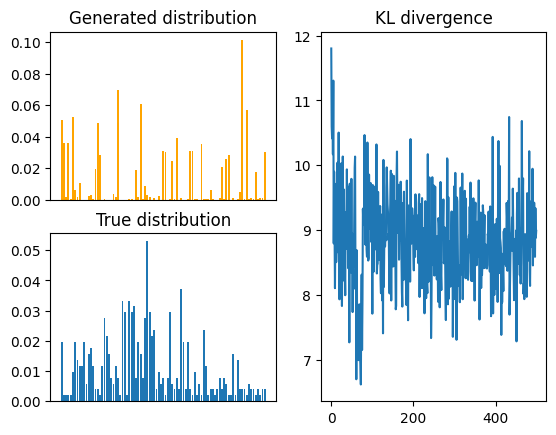

In [2]:
from disassembly.estimate_weights import estimate_weights

G, kls, generated, weights = estimate_weights(
    P=P,
    meta_enzyme=enzymes.meta_enzyme,
    exo_mult_factor=1,
    lr=2,
    n_iterations=500,
    N_T=500,
    alpha=0.05,
)

fig, axs = plt.subplot_mosaic(
    [["generated", "kl"], ["true", "kl"]], width_ratios=[2, 2]
)

generated_sum = {k: 0 for k in generated[0].keys()}

for p_generated in [
    generated[i]
    for i in range(
        len(generated.keys()) - int(len(generated.keys()) / 20), len(generated.keys())
    )
]:
    for k, v in p_generated.items():
        generated_sum[k] += v / 20

axs["true"].bar(P.keys(), [v / sum(P.values()) for v in P.values()])
axs["generated"].bar(
    generated_sum.keys(),
    [v / sum(generated_sum.values()) for v in generated_sum.values()],
    color="orange",
)
axs["kl"].plot(kls)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["kl"].set_title("KL divergence")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

In [3]:
import numpy as np

real_vs_estimated_weights = []
for node in sequence_graph.nodes():
    sum_out_edges = sum(
        [data["weight"] for _, _, data in sequence_graph.out_edges(node, data=True)]
    )
    for source, target, data in sequence_graph.out_edges(node, data=True):
        real_weight = data["weight"] / sum_out_edges
        estimated_weight = G[source][target]["weight"]
        real_vs_estimated_weights.append((real_weight, estimated_weight))
    for source, target, data in G.out_edges(node, data=True):
        if ~sequence_graph.has_edge(source, target):
            estimated_weight = data["weight"]
            real_vs_estimated_weights.append((np.nan, estimated_weight))
print(sum([r for r, _ in real_vs_estimated_weights if str(r) != "nan"]))
print(sum([e for _, e in real_vs_estimated_weights]))

91.00000000000004
152.8604076831517


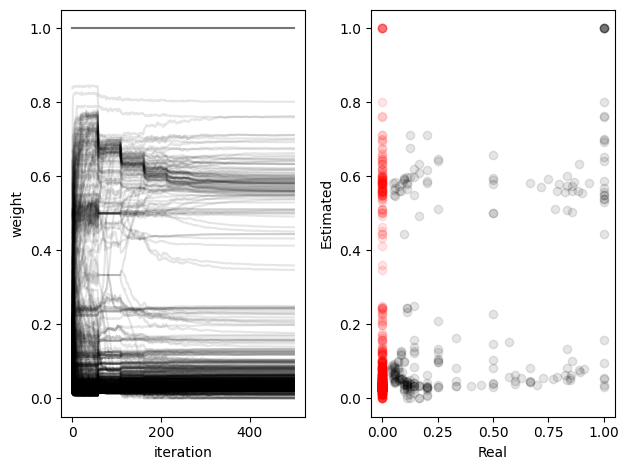

In [4]:
fig, axs = plt.subplots(1, 2)
axs[0].set_ylabel("weight")
axs[0].plot(weights.T, alpha=0.1, color="black")
for r, e in real_vs_estimated_weights:
    if str(r) == "nan":
        axs[1].scatter(0, e, color="red", alpha=0.1)
    else:
        axs[1].scatter(r, e, color="black", alpha=0.1)
axs[1].set_xlabel("Real")
axs[1].set_ylabel("Estimated")
axs[0].set_xlabel("iteration")
plt.tight_layout()
plt.show()

In [5]:
from disassembly.disassembly import get_disassembly_indexes
from disassembly.disassembly import get_disassembly

real_disassembly_indexes = get_disassembly_indexes(sequence_graph)
get_disassembly(P, real_disassembly_indexes)

Removing low prob. (<0.01) edges. Before: 154 | after: 154
 90 / 91 | checking 237 paths
 Averaged DI: 6.88


8203.841146942657

In [6]:
estimated_disassembly_indexes = get_disassembly_indexes(G, min_weight=0.01)
get_disassembly(P, estimated_disassembly_indexes)

Removing low prob. (<0.01) edges. Before: 623 | after: 608
 90 / 91 | checking 492 pathshss
 Averaged DI: 3.89


136.61124213511167

Text(0, 0.5, 'Estimated')

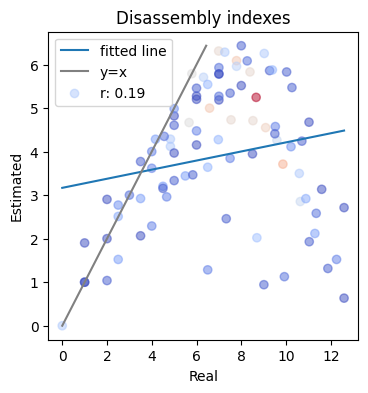

In [7]:
from scipy.stats import linregress
import numpy as np


fig = plt.figure(figsize=(4, 4))
xs = []
ys = []
c = []
for key in P.keys():
    xs.append((real_disassembly_indexes[key]))
    ys.append((estimated_disassembly_indexes[key]))
    c.append(P[key])

regress = linregress(xs, ys)

plt.plot(
    np.linspace(0, max(xs)),
    regress.intercept + np.linspace(0, max(xs)) * regress.slope,
    label="fitted line",
)

plt.plot(np.linspace(0, max(ys)), np.linspace(0, max(ys)), color="gray", label="y=x")
plt.scatter(xs, ys, label=f"r: {regress.rvalue:.2f}", c=c, cmap="coolwarm", alpha=0.5)
plt.legend()
plt.title("Disassembly indexes")

plt.xlabel("Real")
plt.ylabel("Estimated")

In [8]:
import networkx as nx
import pandas as pd

aG = pd.DataFrame(
    nx.adjacency_matrix(G, nodelist=G.nodes()).toarray().T,
    index=G.nodes(),
    columns=G.nodes(),
).sort_index(key=lambda x: x.str.len())
aG = aG[aG.index]
pG = pd.DataFrame(
    nx.adjacency_matrix(sequence_graph, nodelist=G.nodes()).toarray().T,
    index=sequence_graph.nodes(),
    columns=sequence_graph.nodes(),
).sort_index(key=lambda x: x.str.len())
pG = pG[pG.index]

90.00000000000001 90.0 97.91232322018439


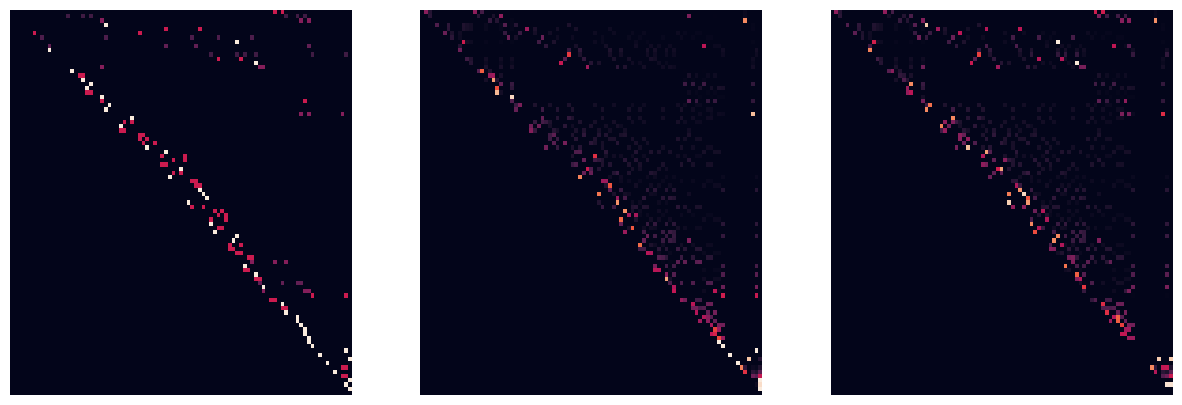

In [9]:
import seaborn as sns
fig, axs = plt.subplots(1,3, figsize=(15,5))

sns.heatmap(pG, ax=axs[0], cbar=None)
sns.heatmap(aG, ax=axs[1], cbar=None)
sns.heatmap(np.abs(pG-aG), ax=axs[2], cbar=None)

print(sum(sum(pG.values)), sum(sum(aG.values)), sum(sum(np.abs(pG-aG).values)))

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])